In [54]:
#about torch...
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

#check our work directory
import os

#to unzip datasets
import zipfile

In [55]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10 # How much to train a model

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [57]:
os.listdir('../input/dogs-vs-cats-redux-kernels-edition')

['.DS_Store',
 'test.zip',
 '.ipynb_checkpoints',
 'train.zip',
 'sample_submission.csv']

In [58]:
os.makedirs('../data', exist_ok=True)

In [59]:
base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
test_dir = '../data/test'

In [60]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [61]:
os.listdir(train_dir)[:5]


['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg']

In [62]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [63]:
len(train_list)

25000

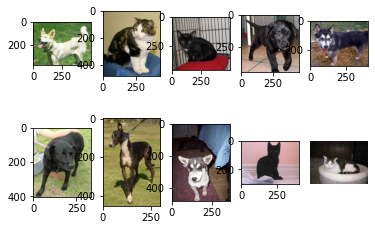

In [64]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [65]:
train_list[0].split('/')[-1].split('.')[0]

'dog'

In [66]:
int(test_list[0].split('/')[-1].split('.')[0])

9733

In [67]:
print(len(train_list), len(test_list))

25000 12500


In [68]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [69]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [70]:
class dataset(torch.utils.data.Dataset):
    #가져와서 처리
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [71]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [72]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [73]:
print(len(train_data), len(train_loader))

20000 200


In [74]:
print(len(val_data), len(val_loader))

5000 50


In [75]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [76]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [77]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [78]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [79]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6325501799583435, train loss : 0.6306196451187134
Epoch : 1, val_accuracy : 0.7088000178337097, val_loss : 0.5704200267791748
Epoch : 2, train accuracy : 0.6947000026702881, train loss : 0.5731917023658752
Epoch : 2, val_accuracy : 0.7217999696731567, val_loss : 0.5410828590393066
Epoch : 3, train accuracy : 0.7264499068260193, train loss : 0.5405353307723999
Epoch : 3, val_accuracy : 0.7427999973297119, val_loss : 0.5186813473701477
Epoch : 4, train accuracy : 0.7319501638412476, train loss : 0.5272234082221985
Epoch : 4, val_accuracy : 0.7519998550415039, val_loss : 0.5064635872840881
Epoch : 5, train accuracy : 0.7429999709129333, train loss : 0.51137775182724
Epoch : 5, val_accuracy : 0.7368000149726868, val_loss : 0.5184708833694458
Epoch : 6, train accuracy : 0.7529000043869019, train loss : 0.49843117594718933
Epoch : 6, val_accuracy : 0.7653999328613281, val_loss : 0.47954824566841125
Epoch : 7, train accuracy : 0.7619503140449524, train loss : 0.4

In [80]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [81]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[('1', 0.4990544021129608),
 ('2', 0.9873009920120239),
 ('3', 0.7840410470962524),
 ('4', 0.9628380537033081),
 ('5', 0.24898546934127808),
 ('6', 0.4439537227153778),
 ('7', 0.1391446888446808),
 ('8', 0.15279901027679443),
 ('9', 0.14488540589809418),
 ('10', 0.06149729713797569),
 ('11', 0.06704465299844742),
 ('12', 0.8953345417976379),
 ('13', 0.09648610651493073),
 ('14', 0.5107242465019226),
 ('15', 0.24621424078941345),
 ('16', 0.02684146538376808),
 ('17', 0.9418078660964966),
 ('18', 0.881718099117279),
 ('19', 0.16418346762657166),
 ('20', 0.5339692831039429),
 ('21', 0.7978121042251587),
 ('22', 0.10119012743234634),
 ('23', 0.8873857259750366),
 ('24', 0.6125447750091553),
 ('25', 0.5872020721435547),
 ('26', 0.8053835034370422),
 ('27', 0.8041670918464661),
 ('28', 0.10606858879327774),
 ('29', 0.7794060111045837),
 ('30', 0.7757938504219055),
 ('31', 0.8611233234405518),
 ('32', 0.05582103133201599),
 ('33', 0.9896019101142883),
 ('34', 0.07732995599508286),
 ('35', 0.3

In [82]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

In [83]:
submission = pd.DataFrame({'id':idx,'label':prob})

In [84]:
submission

,id,label
0,1,0.499054
1,2,0.987301
2,3,0.784041
3,4,0.962838
4,5,0.248985
...,...,...
12495,12496,0.043732
12496,12497,0.076188
12497,12498,0.422711
12498,12499,0.975758


In [85]:
submission.to_csv('result.csv',index=False)

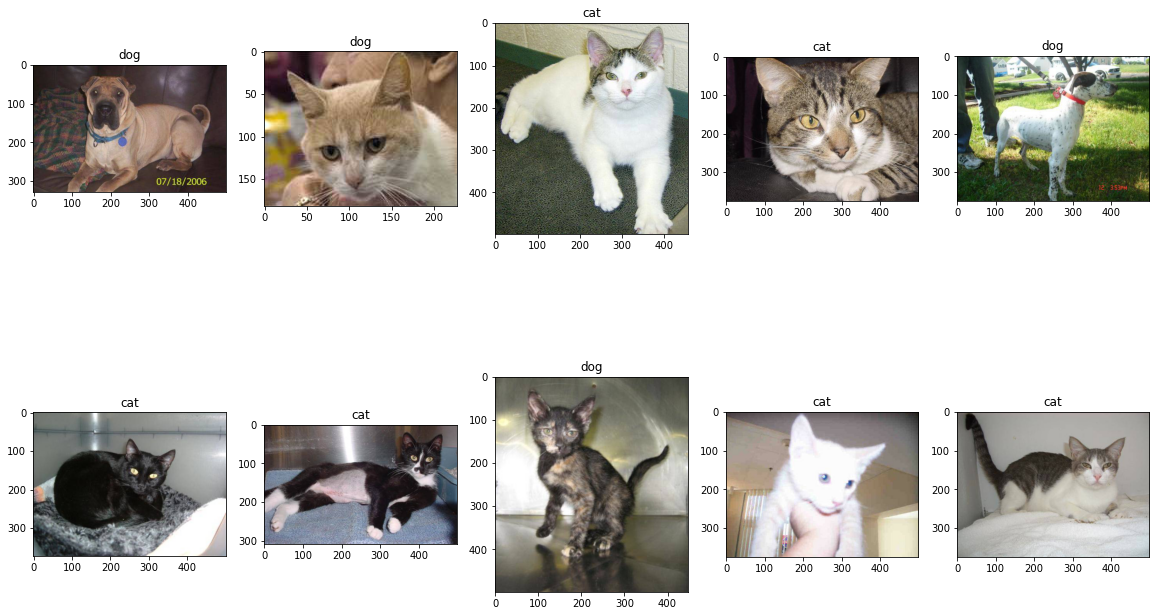

In [86]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)